# Image Classification

We will use the [ResNet model](https://keras.io/api/applications/resnet/) on a [dataset with flower images](https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images) from Kaggle. Inspired by: https://www.kaggle.com/code/koshirosato/classification-of-small-datasets-using-resnet and https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/image.html

The dataset consists of 210 images (128x128x3) and can be divided into 10 classes.

In [ ]:
!pip install -qq shap

Load the dataset with flower images:

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'amllogin'
os.environ['KAGGLE_KEY'] = '35eca611ac64064016cba986e2161cdd'

!kaggle datasets download -d olgabelitskaya/flower-color-images -p /content/dataset

flower-color-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

with zipfile.ZipFile('/content/dataset/flower-color-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [ ]:
import pandas as pd

df = pd.read_csv('/content/dataset/flower_images/flower_images/flower_labels.csv')
df = df.replace({0:'phlox',
                 1:'rose',
                 2:'calendula',
                 3:'iris',
                 4:'leucanthemum maximum',
                 5:'bellflower',
                 6:'viola',
                 7:'rudbeckia laciniata',
                 8:'peony',
                 9:'aquilegia'})
df

,file,label
0,0001.png,phlox
1,0002.png,phlox
2,0003.png,calendula
3,0004.png,phlox
4,0005.png,phlox
...,...,...
205,0206.png,viola
206,0207.png,phlox
207,0208.png,leucanthemum maximum
208,0209.png,viola


Check class balance:

<Axes: >

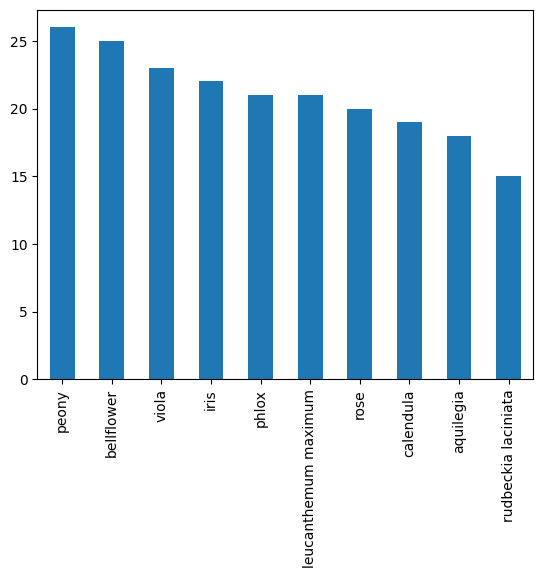

In [ ]:
df.label.value_counts().plot.bar()

Split dataset to train and test:

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=666,
                                     stratify=df['label'].values)

def create_datasets(df, img_size):
    imgs = []
    for file_name in tqdm(df['file']):
        img = cv2.imread('/content/dataset/flower_images/flower_images/' + file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
    # not normalize
    imgs = np.array(imgs)
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, 256)
test_imgs, test_df = create_datasets(test_df, 256)

100%|██████████| 42/42 [00:00<00:00, 391.81it/s]


Load model:

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras import Input

inp = Input(shape=(256,256,3))
num_classes = len(df.label.value_counts())
model = ResNet50(input_shape=(256,256,3), weights='imagenet', include_top=False)

# freeze ResNet
model.trainable = False
model = model(inp)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(num_classes, activation='softmax')(model)
model = Model(inputs=inp, outputs=model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23587712 (89.98 MB)
______________

In [ ]:
model.fit(train_imgs,
          train_df,
          batch_size=32,
          epochs=20)

Epoch 1/20
6/6 [==============================] - 8s 104ms/step - loss: 2.9522 - accuracy: 0.1190
Epoch 2/20
6/6 [==============================] - 1s 99ms/step - loss: 2.1397 - accuracy: 0.2857
Epoch 3/20
6/6 [==============================] - 1s 99ms/step - loss: 1.5309 - accuracy: 0.5119
Epoch 4/20
6/6 [==============================] - 1s 98ms/step - loss: 1.3924 - accuracy: 0.5357
Epoch 5/20
6/6 [==============================] - 1s 98ms/step - loss: 1.1182 - accuracy: 0.6071
Epoch 6/20
6/6 [==============================] - 1s 98ms/step - loss: 0.8366 - accuracy: 0.7202
Epoch 7/20
6/6 [==============================] - 1s 98ms/step - loss: 0.7551 - accuracy: 0.7440
Epoch 8/20
6/6 [==============================] - 1s 98ms/step - loss: 0.6035 - accuracy: 0.7917
Epoch 9/20
6/6 [==============================] - 1s 99ms/step - loss: 0.5289 - accuracy: 0.8393
Epoch 10/20
6/6 [==============================] - 1s 99ms/step - loss: 0.4423 - accuracy: 0.8571
Epoch 11/20
6/6 [===========

[0.34632015228271484, 0.9523809552192688]

In [ ]:
model.evaluate(test_imgs, test_df)

2/2 [==============================] - 0s 75ms/step - loss: 0.3463 - accuracy: 0.9524


[0.34632015228271484, 0.9523809552192688]

Interpret the model:

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import shap

def f(X):
  tmp = X.copy()
  preprocess_input(tmp)
  return model(tmp)

masker = shap.maskers.Image('inpaint_telea', test_imgs[0].shape)
masker

In [ ]:
explainer = shap.Explainer(f, masker, output_names=df['label'].unique().tolist())
explainer

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [00:50<01:47, 15.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [01:13<01:49, 18.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [01:36<01:41, 20.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [02:03<01:30, 22.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [02:29<01:10, 23.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [02:55<00:48, 24.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [03:20<00:24, 24.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [03:44<00:00, 24.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [04:14, 25.48s/it]


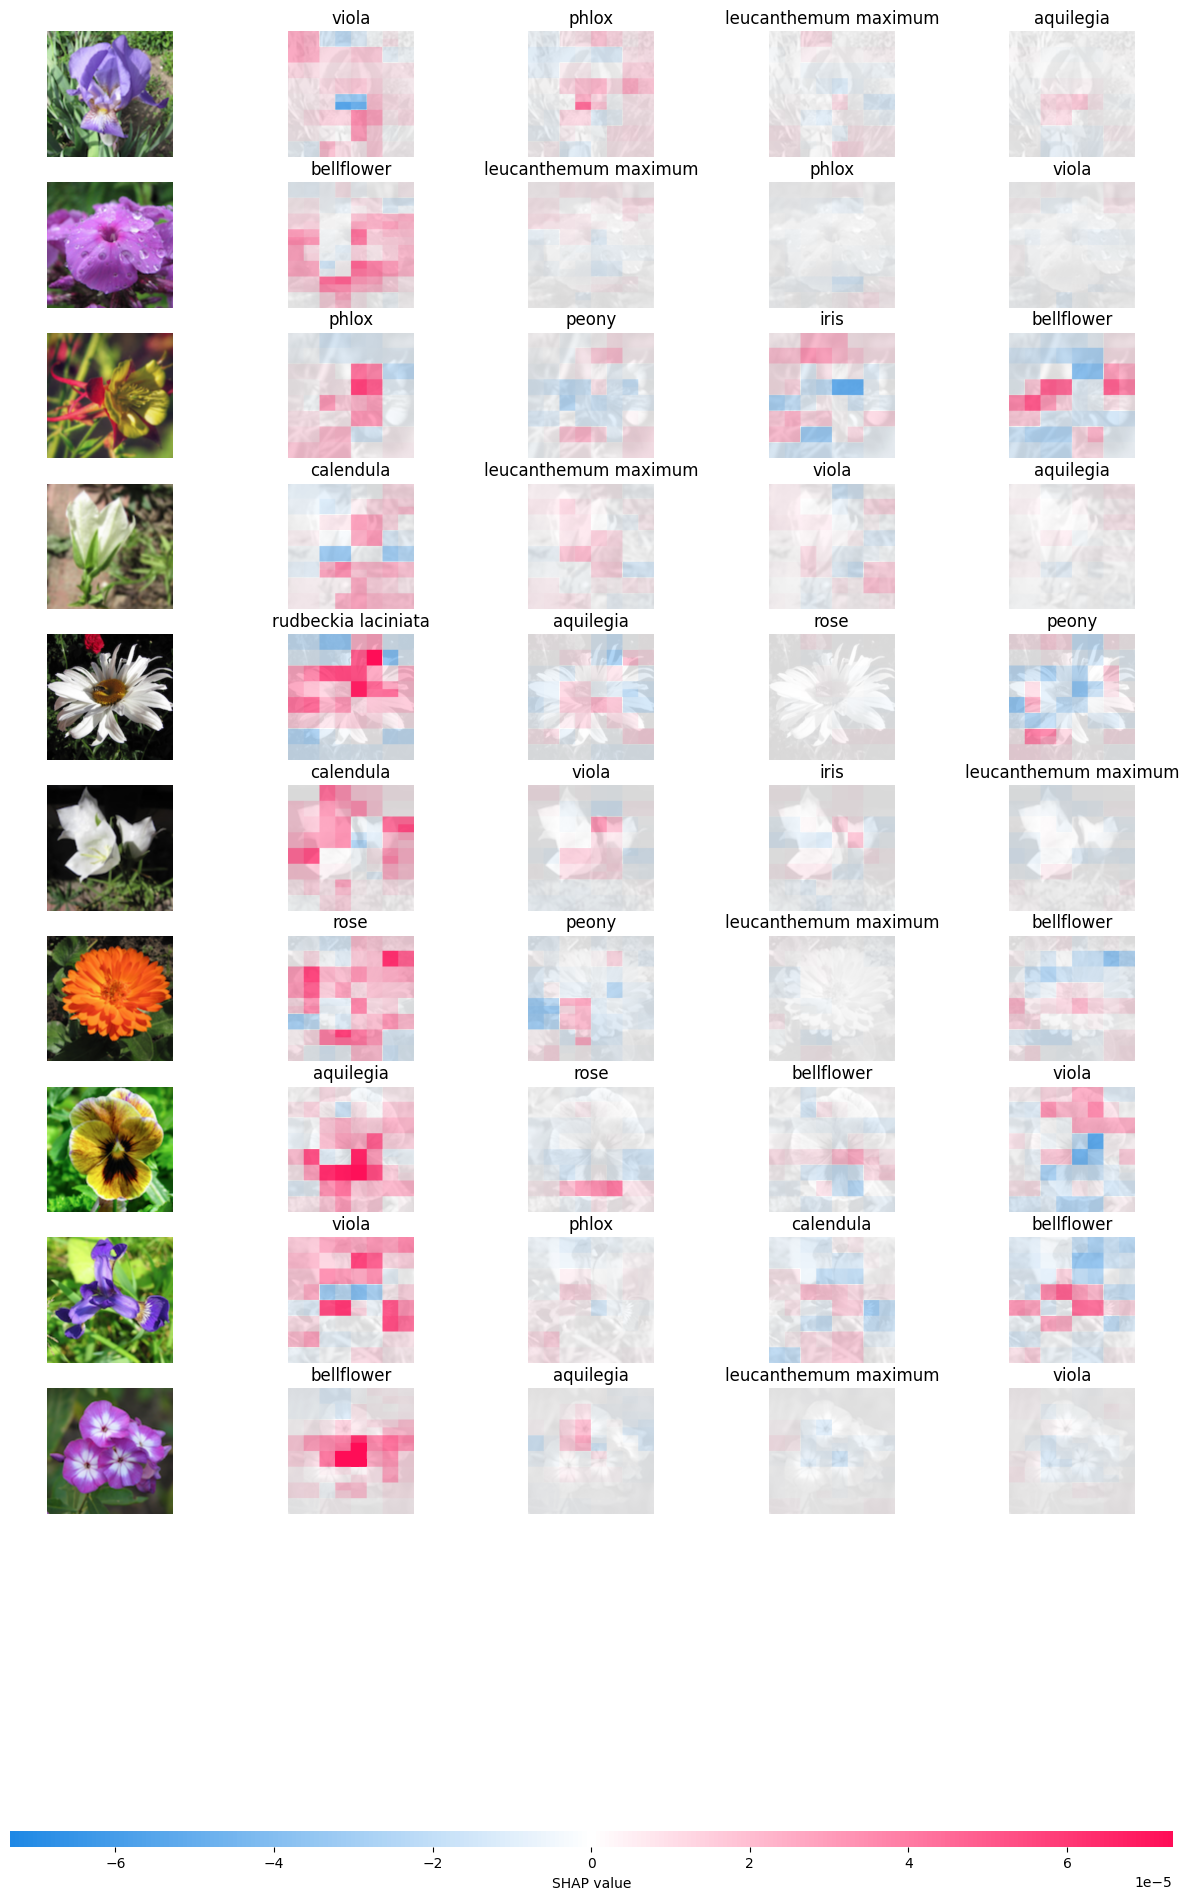

In [ ]:
# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    test_imgs[0:10], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]  # 4 so that we get explanations for top 4 classes
)
shap.image_plot(shap_values)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [07:39<16:21, 140.15s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [11:31<17:49, 178.32s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [15:21<16:28, 197.70s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [20:00<15:03, 225.99s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [24:21<11:52, 237.62s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [28:38<08:07, 243.64s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [32:44<04:04, 244.54s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [36:46<00:00, 243.64s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [41:47, 250.75s/it]


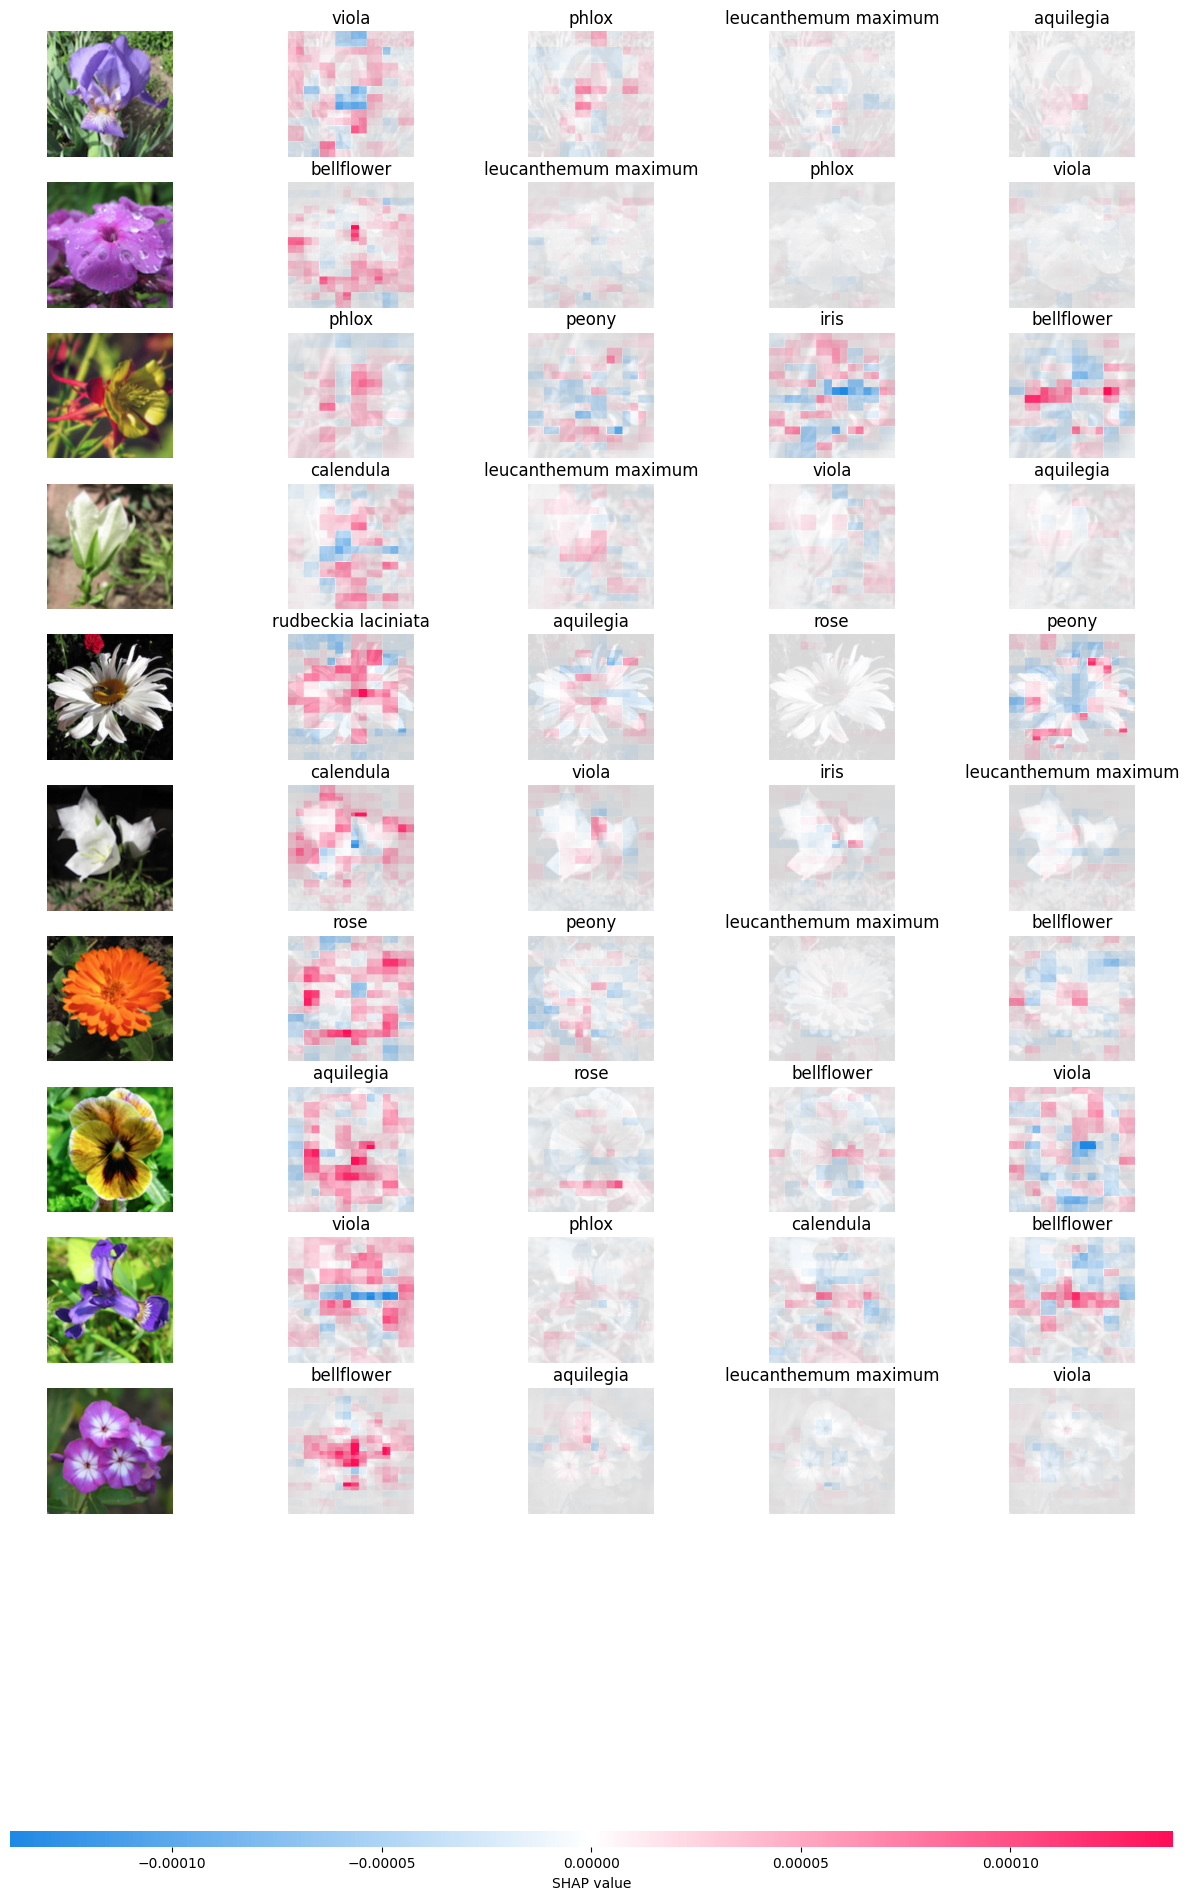

In [ ]:
shap_values = explainer(
    test_imgs[0:10], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)
shap.image_plot(shap_values)